# Data
#### We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

The data is stored in the ./data/ directory

In [444]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

In [445]:
headers = ["BI-RADS", "Age", "Shape", "Margin", "Density", "Severity"]
dataset = pd.read_csv('./data/mammographic_masses.data', header=None, names=headers, na_values='?')
dataset.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [446]:
dataset.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [447]:
dataset.isna().sum()

BI-RADS      2
Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [448]:
clean.corr()

,BI-RADS,Age,Shape,Margin,Density,Severity
BI-RADS,1.000000,0.094623,0.180120,0.157771,0.028356,0.223826
Age,0.094623,1.000000,0.380096,0.420913,0.052417,0.455216
Shape,0.180120,0.380096,1.000000,0.738014,0.073969,0.564763
Margin,0.157771,0.420913,0.738014,1.000000,0.124860,0.574498
Density,0.028356,0.052417,0.073969,0.124860,1.000000,0.068651
Severity,0.223826,0.455216,0.564763,0.574498,0.068651,1.000000


This is a binary classification problem, our goal is to correctly predict the severity of a cancer based on the other features. 

The data work-flow is inspired by this video: https://www.youtube.com/watch?v=MpFZUshKypk

In [449]:
def stage_details(f):
    def wrapper(dataframe, *args, **kwargs):
        result = f(dataframe, *args, **kwargs)
        print(f'<{f.__name__}> dataframe shape: {result.shape}')
        return result
    
    return wrapper

In [450]:
@stage_details
def start_pipeline(dataframe):
    return dataframe.copy()

@stage_details
def format_data(dataframe):
    dataframe = dataframe.drop(columns=["BI-RADS"])
    return dataframe

@stage_details
def clean_data(dataframe):
    imp = IterativeImputer(max_iter=10, random_state=0)
    clean = dataframe.dropna()
    imp.fit(clean)
    imputed = np.round(imp.transform(dataframe))
    
    imputed_dataframe = pd.DataFrame(data=imputed, columns=["Age", "Shape", "Margin", "Density", "Severity"])
    return imputed_dataframe

@stage_details
def normalise_data(dataframe):
    scaler = StandardScaler()
    
    labels = dataframe['Severity']
    dataframe = dataframe.drop(columns=['Severity'])
    
    scaler.fit(dataframe)
    normalised_data = scaler.transform(dataframe)
    normalised_dataframe = pd.DataFrame(data=normalised_data, columns=["Age", "Shape", "Margin", "Density"])
    normalised_dataframe['Severity'] = labels
    return normalised_dataframe

@stage_details
def shuffle_data(dataframe):
    return dataframe.sample(frac=1)

@stage_details
def visualise_data(dataframe):
    sns.pairplot(dataframe, hue='Severity', height=2.5)
    return dataframe


In [451]:
prepared_data = (dataset.pipe(start_pipeline)
        .pipe(format_data)
        .pipe(clean_data)
        .pipe(normalise_data)
        .pipe(shuffle_data))

X = prepared_data.drop(columns=['Severity'])
Y = prepared_data['Severity']

<start_pipeline> dataframe shape: (961, 6)
<format_data> dataframe shape: (961, 5)
<clean_data> dataframe shape: (961, 5)
<normalise_data> dataframe shape: (961, 5)
<shuffle_data> dataframe shape: (961, 5)


# Approach \#1, Decision Tree

In [452]:
from sklearn.model_selection import train_test_split

In [453]:
TrainX, TestX, TrainY, TestY = train_test_split(X, Y, train_size=0.25, shuffle=True)

print(f'Original: X: {X.shape}, Y: {Y.shape}')
print(f'Train: X: {TrainX.shape}, Y: {TrainY.shape}.')
print(f'Test: X: {TestX.shape}, Y: {TestY.shape}.')

Original: X: (961, 4), Y: (961,)
Train: X: (240, 4), Y: (240,).
Test: X: (721, 4), Y: (721,).


In [454]:
from sklearn.tree import DecisionTreeClassifier

In [455]:
Tree = DecisionTreeClassifier()
s = Tree.fit(TrainX, TrainY)


In [456]:
s.score(TestX, TestY)

0.7073509015256588

Use cross validation score instead of naive train-test split 

In [457]:
from sklearn.model_selection import cross_val_score

In [458]:
scores = cross_val_score(s, TestX, y=TestY, cv=10, scoring='accuracy')
print(f"accuracy: {np.round(scores.mean(), decimals=3)} (+/- {np.round(scores.std() * 2, decimals=3)})")

accuracy: 0.714 (+/- 0.059)


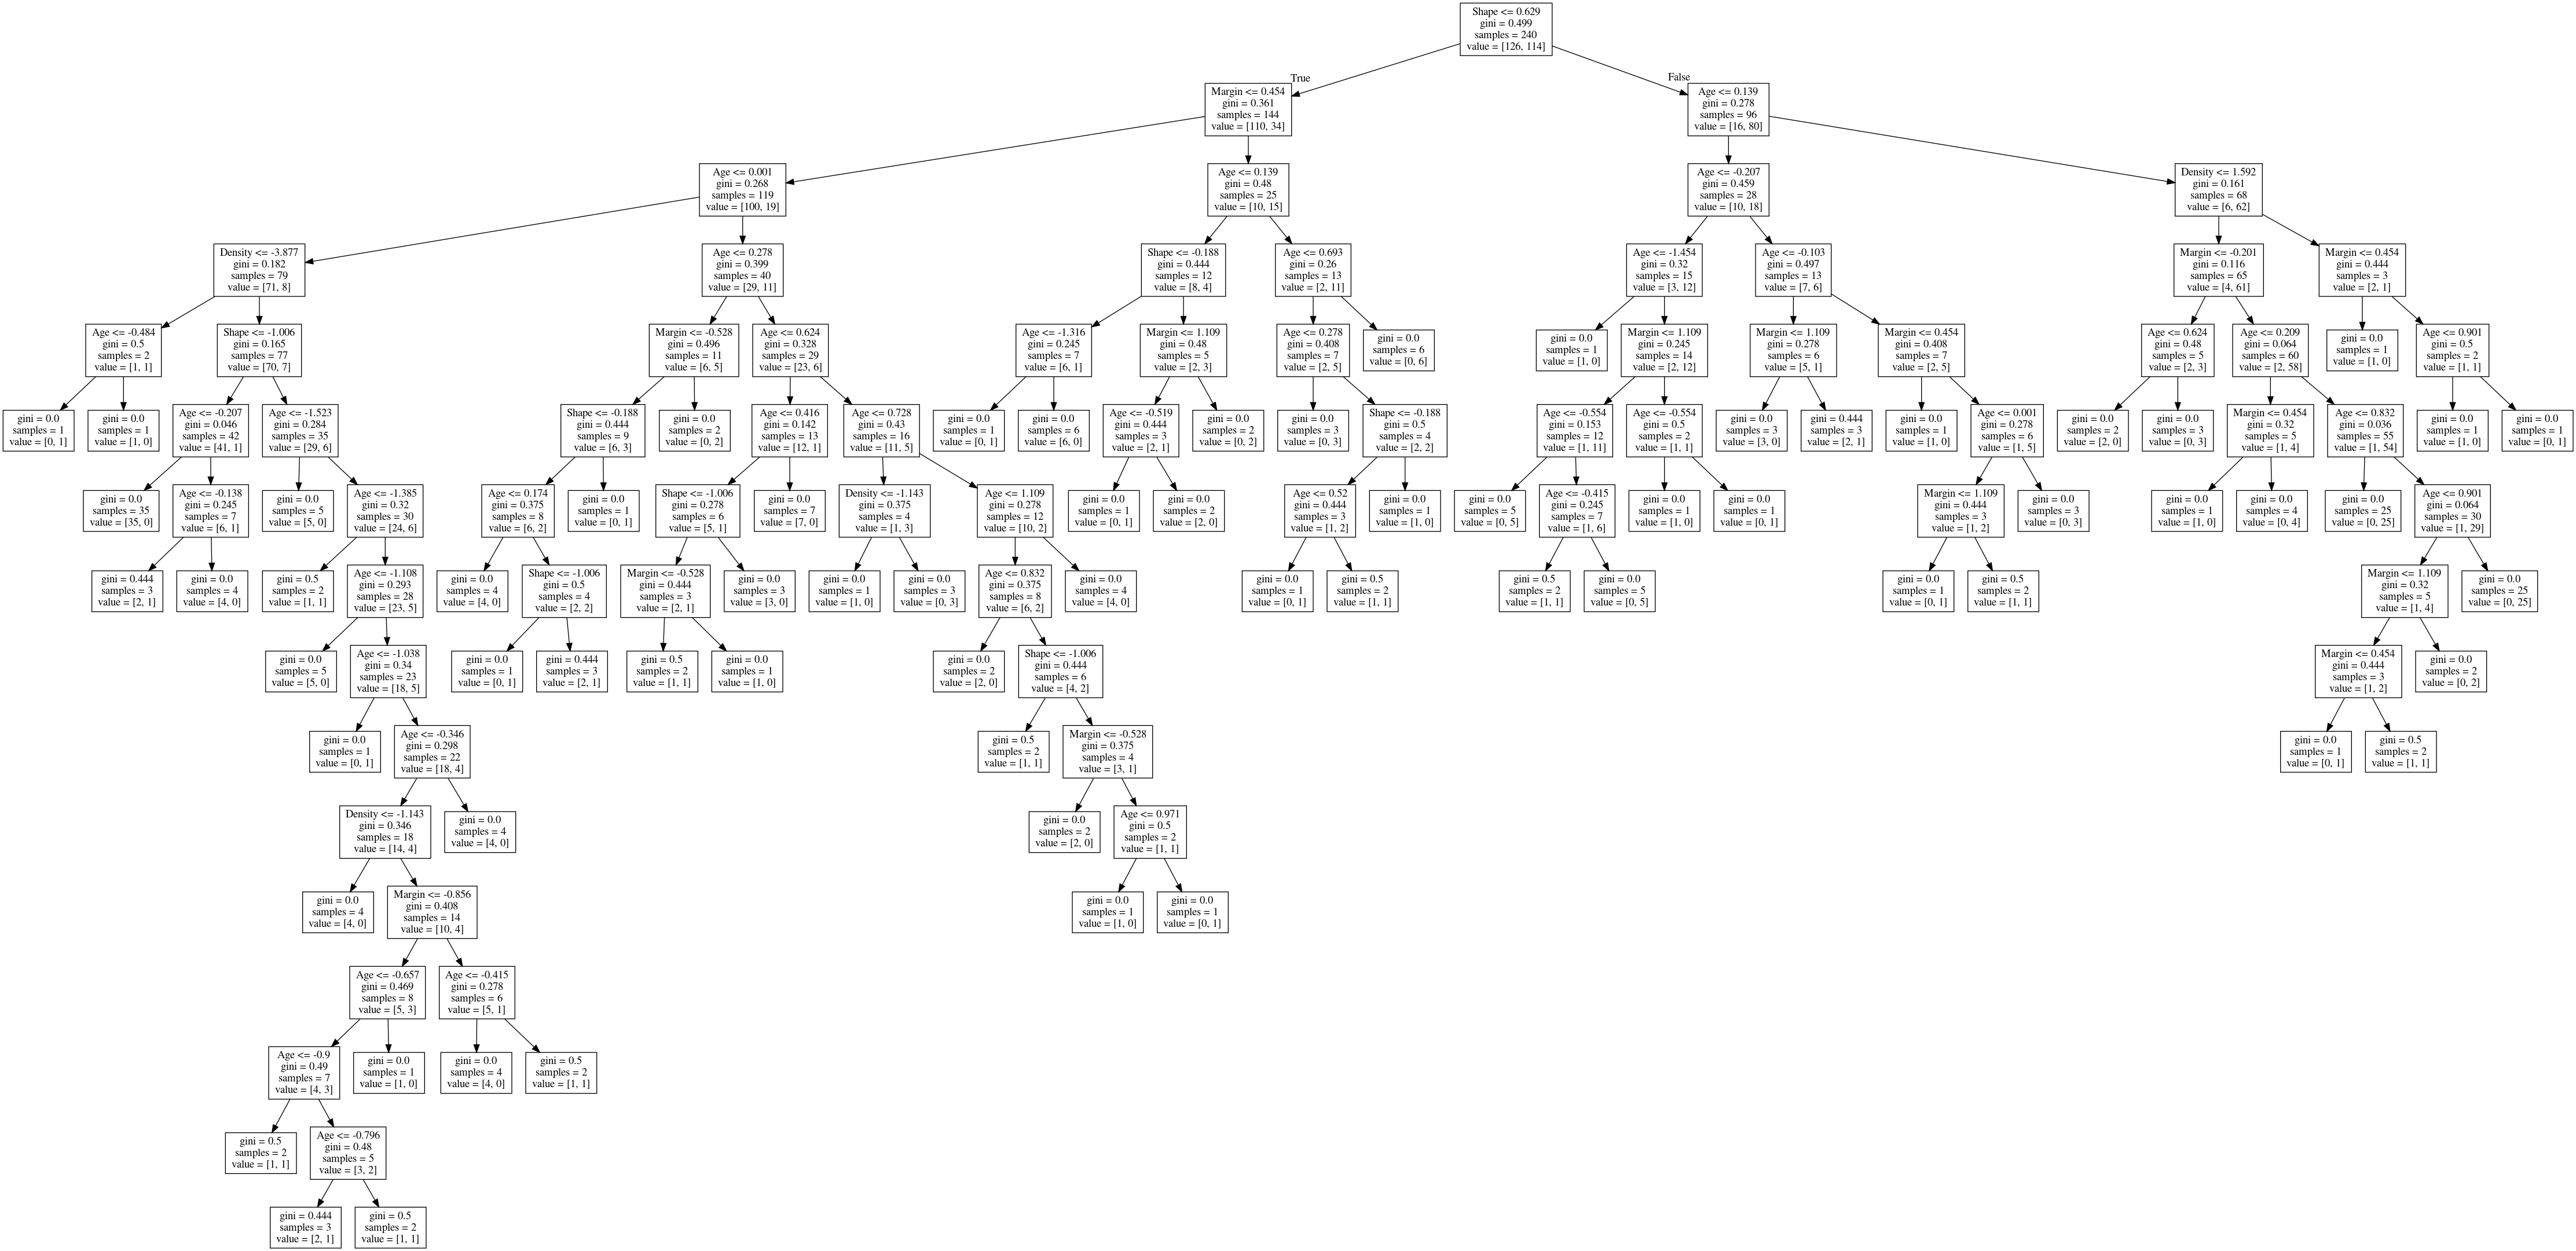

In [459]:
from IPython.display import Image  
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(s, out_file=dot_data,  
                         feature_names=["Age", "Shape", "Margin", "Density"])  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
with open("tree.png", "wb") as png:
    png.write(graph.create_png())

img

### Now to use a RandomForestClassifier instead

In [460]:
from sklearn.ensemble import RandomForestClassifier

In [461]:
RFclassifier = RandomForestClassifier(n_estimators=100)
RFclassifier.fit(TrainX, TrainY)

RFscores = cross_val_score(RFclassifier, TestX, y=TestY, cv=10, scoring='accuracy')
print(f"accuracy: {np.round(RFscores.mean(), decimals=3)} (+/- {np.round(RFscores.std() * 2, decimals=3)})")

accuracy: 0.741 (+/- 0.07)


# Approach \#2, SVM classifier

In [462]:
from sklearn.svm import SVC

In [463]:
SVClassifier = SVC(C=1, kernel='linear', gamma='auto')
SVClassifier.fit(TrainX, TrainY)
SVCscores = cross_val_score(SVClassifier, TestX, y=TestY, cv=10, scoring='accuracy')
print(f"accuracy: {np.round(SVCscores.mean(), decimals=3)} (+/- {np.round(SVCscores.std() * 2, decimals=3)})")

accuracy: 0.795 (+/- 0.054)


# Approach \#3, K-Nearest-Neighbor classifier

In [464]:
from sklearn.neighbors import KNeighborsClassifier

In [487]:
best_acc = 0.0
best_acc_i = None
for i in range(1, 50):
    KNNClassifier = KNeighborsClassifier(n_neighbors=i)
    KNNClassifier.fit(TrainX, TrainY)
    KNNScores = cross_val_score(KNNClassifier, TestX, y=TestY, cv=10, scoring='accuracy')
    if np.round(KNNScores.mean(), decimals=3) > best_acc:
        best_acc = np.round(KNNScores.mean(), decimals=3)
        best_acc_i = i
        print(f'i: {i}')
        print(f"accuracy: {np.round(KNNScores.mean(), decimals=3)} (+/- {np.round(KNNScores.std() * 2, decimals=3)})")

i: 1
accuracy: 0.727 (+/- 0.09)
i: 3
accuracy: 0.772 (+/- 0.092)
i: 5
accuracy: 0.802 (+/- 0.067)
i: 15
accuracy: 0.804 (+/- 0.062)
i: 32
accuracy: 0.806 (+/- 0.04)
i: 34
accuracy: 0.807 (+/- 0.044)
